# Chapter 1: A stats review


Every random variable we consider in this notebook has mean zero, because it makes the math a lot easier. Consider $n$ IID (independent and identically-distributed) variables drawn from a Gaussian:

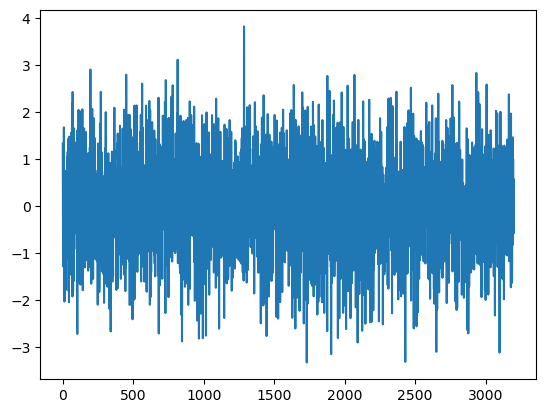

In [327]:
import numpy as np
import pylab as plt

n = 3200
plt.plot(np.random.standard_normal(size=n))

The numbers above are uncorrelated. In particular, the expected product (called the covariance) of any two of these variables is 0, and the expected product of any variable with itself (the variance) is 1. 

What if the covariance of $n$ different variables was nonzero? What if the expected product of two variables $x_i$ and $x_j$ followed an exponential function:

\begin{equation}
\mathbf{\Sigma}_{ij} = \langle x_i \cdot x_j \rangle = \exp \big ( -a \cdot | i - j | \big )
\end{equation}

where $a$ is some parameter. This defines an $n$-by-$n$ covariance matrix, which when visualized looks like:

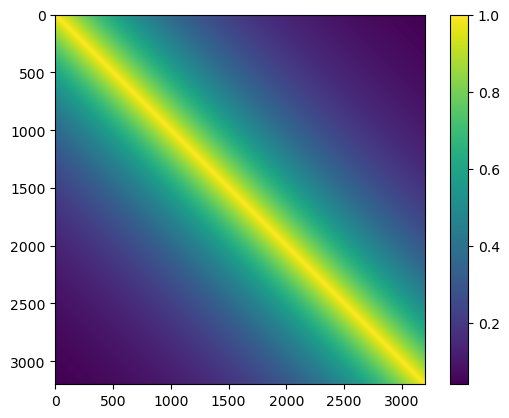

In [328]:
exp_cov_fun = lambda i, j, a : np.exp(-a*np.abs(i-j))

index = np.arange(n)
I, J = np.meshgrid(index, index)
C = exp_cov_fun(I, J, a=1e-3)

plt.imshow(C)
plt.colorbar()

We can generate variables with this covariance matrix by using the magic of linear algebra. Because all covariance matrices must be positive definite and real (as all their eigenvalues are positive), they can be represented as a product 

\begin{equation}
\mathbf{\Sigma} = \mathbf{G} \mathbf{G}^\dagger
\end{equation}

where $G$ is a unique matrix called the Cholesky decomposition, and $\dagger$ is the transpose. This means that we can "correlate" variables as $\mathbf{y} = \mathbf{G}\mathbf{x}$, because as long as the members of the vector $\mathbf{x}$ are IID variables each with unit variance, we have

\begin{equation}
\big \langle (\mathbf{G} \mathbf{x})^\dagger \mathbf{G} \mathbf{x} \big \rangle  = \mathbf{G} \mathbf{I} \mathbf{G}^\dagger = \mathbf{\Sigma}
\end{equation}

Let's try it:

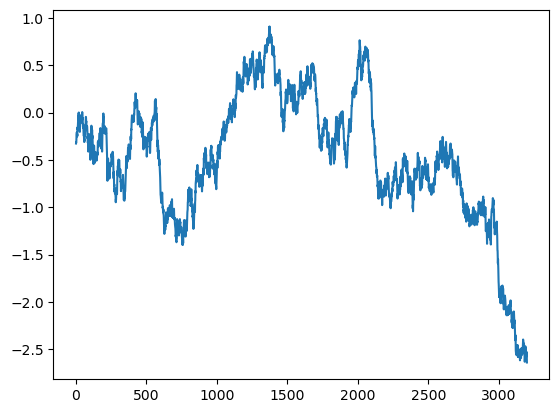

In [329]:
G = np.linalg.cholesky(C)
x = np.random.standard_normal(n)
y = np.matmul(G, x)
plt.plot(y)

Neat! We have some structure in our randomness (this is why the covariance defines another concept called the structure function.) We can also see that there is some information to be had here: variables near to each other are more correlated, and as such can predict each other. We can change the covariance function and see how it changes the structure, Let's try a radial basis function (RBF):

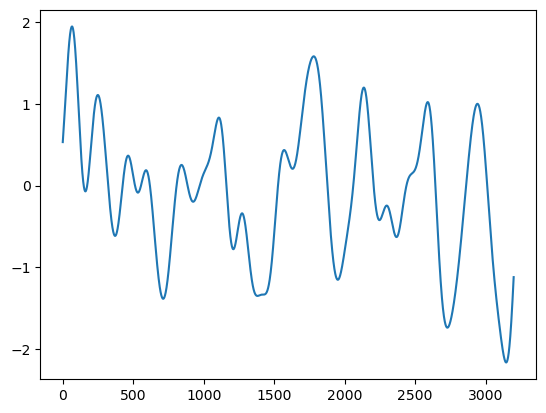

In [330]:
rbf_cov_fun = lambda i, j, a : np.exp(-a*np.square(i-j))

index = np.arange(n)
I, J = np.meshgrid(index, index)
C = rbf_cov_fun(I, J, a=1e-4) + 1e-12 * np.eye(n) 
G = np.linalg.cholesky(C)
x = np.random.standard_normal(n)
y = np.matmul(G, x)

plt.plot(y)

This one is smoother. Note that when we defined the covariance matrix in the cell above, we added a very small "jitter" to the diagonal. Although the matrix we are trying to compute is positive definite, the precision of whatever language we're working in sometimes introduces some chaotic effects, especially when trying to compute a matrix inverse (which the Cholesky algorithm does). This will be important later.


The above examples are not just a collection of random variables, but rather a "process", which is a fancy name for when random variables are organized in time or space. 

# Chapter 2: The Gaussian Process

A Gaussian Process is a process where any given variable is normally distributed. It has a lot of special properties, but the most important is Gaussian process regression. Consider some known $\mathbf{k}$ and unknown $\mathbf{u}$ data that are part of the same Gaussian process. It is then the case that the mean of each unknown data point is the vector 

$\big \langle \mathbf{u} \big \rangle = \big \langle \mathbf{u}^\dagger\mathbf{k} \big \rangle \big \langle \mathbf{k}^\dagger \mathbf{k} \big \rangle^{-1} \mathbf{k}$

The derivation of this is very fun, but not important. But this equation is the most important thing to know in doing GPR (it's worth memorizing). And she has a sister: 

$\big \langle \mathbf{u}^2 \big \rangle = \text{diag} \Big ( \big \langle \mathbf{u}^\dagger \mathbf{u} \big \rangle - \big \langle \mathbf{u}^\dagger\mathbf{k} \big \rangle \big \langle \mathbf{k}^\dagger \mathbf{k} \big \rangle^{-1} \big  \langle \mathbf{k}^\dagger\mathbf{u} \big \rangle \Big )$

who tells us the variance. Why are these equations important? If we look a random process, we can try to model its covariance as some function (for example, an RBF) of some underlying parameters (for example, how far apart they are in space). Then we can compute all of the ugly expectations above as nice covariance matrices, which we can plug in and use on our known data to infer the posterior distribution of our unknown data. 

It turns out that this has some extremely useful practical applications, as we will soon see. 



# Chapter 3: Likelihoods

(This is not as important as the previous chapter, but this is what software like GPyTorch is computing under the hood.)

In principle, a Gaussian process can generate any possible set of values out of sheer randomness; but that doesn't mean it's likely. If you flip a coin a hundred times and it lands on heads ninety times, then your model that coin flips are fifty-fifty is probably a bad model (or you have a bad coin). Likewise, if we start to measure a realized Gaussian process, we soon start to see which covariance models are more or less likely to have generated it. 

We do need to start with some assumption about the structure of the process, which is often physically motivated: is it periodic (for example, seasonal temperature measurements), is it scale-invariant (for example, distributions of water vapor in the atmosphere), or is it something else?. We usually pick some function (called a kernel), but also give it some degrees of freedom (which we denote $\mathbf{\theta}$) that our model will fit to. In the above examples, we want our model to know that seasonal temperatures recur every year (and not every six months, or two years) and that clouds are typically around a kilometer in diameter (and not a few meters, or thousands of kilometers). The convention is to call them hyperparameters to distinguish them from parameters (the known inputs, like position in time or space). The model covariance will be the kernel function of the parameters and hyperparameters. 

After we choose our kernel, how we quantify likelihoods of hyperparameters? We can use Bayes' rule. The probability of our hyperparameters being correct given some data $\mathbf{d}$ is

\begin{equation}
P(\text{$\mathbf{\theta}$ is correct | $\mathbf{d}$}) = \frac{P(\text{$\mathbf{d}$ | $\mathbf{\theta}$ is correct}) \cdot P(\text{$\mathbf{\theta}$ is correct})}{P(\text{$\mathbf{d}$})}
\end{equation}

If we assume that all $\mathbf{\theta}$ are equally likely before we see any data (a "flat" prior), then the only term that changes for a constant dataset is $P(\text{this kernel is correct | $\mathbf{d}$})$. So we can find the most likely kernel by maximizing it. And guess what? This too has a nifty expression for a correlated Gaussian process:

\begin{equation}
P(\text{$\mathbf{\theta}$ is correct | $\mathbf{d}$}) \propto \text{det} \big ( \mathbf{K}(\mathbf{\theta}) \big )^{1/2} \exp \Big [ -\frac{1}{2}\mathbf{d}^\dagger \mathbf{K}(\mathbf{\theta})^{-1} \mathbf{d} \Big ]
\end{equation}

where $d$ is the data we observe, and our kernel $\mathbf{K}(\theta)$ is what our kernel and hyperparameters estimate the covariance of our data are. So, we optimize our hyperparameters to maximize the term on the right in order to get the best kernel. Bayes rule is fun!


An extremely fun fact: the regression equations in Chapter 2 are also just Bayes' rule!


# Chapter 4: GPyTorch

If you don't like linear algebra, that's ok, because GPyTorch does it for us. Let's do a simple demo. First, some training data: randomly scattered points in two dimensions, who each have a scalar value. We correlate it with an RBF kernel, and give it three hyperparameters: a variance of 2, a horizontal lengthscale of 0.1, and a vertical lengthscale of 0.5:

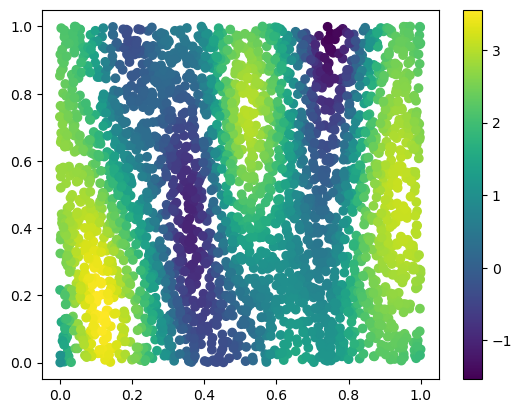

In [331]:
variance = 2
x_lengthscale = 1e-1
y_lengthscale = 5e-1

X, Y = np.random.uniform(low=0, high=1, size=(2, n))


C = variance * np.exp(-0.5*(np.square(np.subtract.outer(X, X)/x_lengthscale) 
                         + np.square(np.subtract.outer(Y, Y)/y_lengthscale))) + 1e-12 * np.eye(n) # 2 and 1e-2 are our hyperparameters, plus some jitter 
G = np.linalg.cholesky(C) 
data = np.matmul(G, np.random.standard_normal(n))
plt.scatter(X, Y, c=data)
plt.colorbar()

Let's make a GP! The below is taken right from the GPyTorch docs. We first instantiate a model:

In [332]:
import torch, gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
train_index = np.random.choice(n, int(n/100))
    
train_x, train_y = torch.as_tensor(np.c_[X, Y][train_index]).float(), torch.as_tensor(data[train_index]).float()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

The GP is only allowed to see one percent of the data. It's pretty sparse:

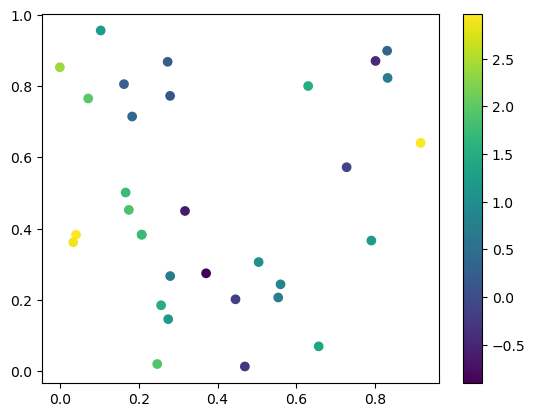

In [333]:
plt.scatter(*train_x.T, c=train_y)
plt.colorbar()

And we train it, to learn the correct hyperparameters:

In [334]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'iter {i+1} / {training_iter} : loss = {loss.item():.03f} | lengthscales = {model.covar_module.base_kernel.lengthscale.detach().numpy().round(3)} | variance = {model.covar_module.outputscale.detach().numpy():.02f}')
    optimizer.step()

iter 1 / 100 : loss = 1.560 | lengthscales = [[0.693 0.693]] | variance = 0.69
iter 11 / 100 : loss = 1.372 | lengthscales = [[0.312 1.268]] | variance = 1.29
iter 21 / 100 : loss = 1.208 | lengthscales = [[0.136 1.307]] | variance = 1.78
iter 31 / 100 : loss = 0.996 | lengthscales = [[0.097 0.713]] | variance = 2.11
iter 41 / 100 : loss = 0.799 | lengthscales = [[0.106 0.42 ]] | variance = 1.78
iter 51 / 100 : loss = 0.645 | lengthscales = [[0.094 0.422]] | variance = 1.39
iter 61 / 100 : loss = 0.542 | lengthscales = [[0.092 0.443]] | variance = 1.52
iter 71 / 100 : loss = 0.472 | lengthscales = [[0.093 0.431]] | variance = 1.60
iter 81 / 100 : loss = 0.428 | lengthscales = [[0.094 0.418]] | variance = 1.54
iter 91 / 100 : loss = 0.399 | lengthscales = [[0.095 0.417]] | variance = 1.58


Hey, not bad! And it was super fast! But we still do well even when we get the hyperparameters a little (or a lot) wrong. Let's predict!

In [335]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.as_tensor(np.c_[X, Y]).float()
    observed_pred = likelihood(model(test_x))

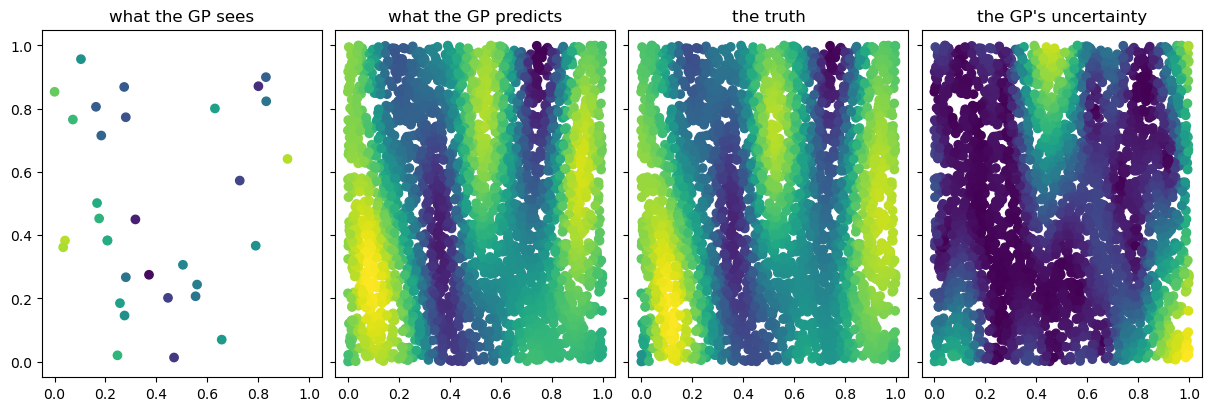

In [341]:
import matplotlib as mpl

fig, axes = plt.subplots(1,4,figsize=(12,4),sharex=True,sharey=True,constrained_layout=True)

norm = mpl.colors.Normalize(*np.percentile(data,q=[1,99]))

axes[0].scatter(*train_x.T, c=train_y, norm=norm); axes[0].set_title('what the GP sees')
axes[1].scatter(X, Y, c=observed_pred.mean); axes[1].set_title('what the GP predicts')
axes[2].scatter(X, Y, c=data); axes[2].set_title('the truth')
axes[3].scatter(X, Y, c=np.sqrt(observed_pred.variance.detach().numpy())); axes[3].set_title('the GP\'s uncertainty')

plt.show()

# Chapter 5: Applications in optimization

From only a small number of samples, our GP can efficiently and effectively learn the correlations of a function over a parameter space, and map out the actual values in an arbitrary number of dimensions. It also allows for the definition of incentive-maximizing learning strategies, without the use of any vague reinforcement training. For example, it could sample where it learns the most about its hyperparameters, where it learns the most about the parameter space, or just where it thinks the function might be highest or lowest. These are all computable from the Gaussian process. 


It should be clear why this is ideal for beamline optimization, where function acquisition is expensive and alignment problems can get very dimensional very quickly. Actually, the beam's spot size at the endstation varies a lot lke the function above under large misalignments of mirrors. Even a simple GP finds success with the beam, but there is no limit to how sophisticated you make your model. 